[![Open in Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/bsipocz/astroML-notebooks/notebooks?filepath=chapter6/Figure6-347.ipynb)

# Density Estimation for SDSS "Great Wall"

## Introduction
In this notebook, we are going to estimate density of galaxies in the SDSS "Great Wall" using different methods.  
Raw data are often displayed in a way like scattered point or sorted with different sized bins in histogram. However, it hard to see a smooth distribution pattern in dots and histogram bins. Therefore, we need estimators for mining the underlying distribution pattern.   


Firstly, we will apply **Kernal Density Estimation (KDE)** with different kernels (Gaussian, top-hat, and exponential kernels).
For a set of measurements ${x_i}$, the KDE at x is 

$$\hat{f_{N}}(x) = \frac{1}{Nh^D} \sum_{i=1}^{N} K(\frac{d(x,x_i)}{h})$$  

where D is the dimensions of the parameter space.


Secondly, we will use **K-Nearest-Neighbor Estimation** with different structure scales (different K values). The estimated function is calculated as

$$\hat{f_K}(x) = \frac{K}{V_D(d_K)}$$  
  
Lastly, we will use **Gaussian Mixture Model (GMM)** on the same dataset. The density function of points is given by

$$\rho(x) = Np(x) = N \sum_{j=1}^{M} \alpha_j \mathcal{N}(\mu_j, \Sigma_j)$$

## Import Data and Methods
The sample data used in this notebook is the a galaxy sample contains 8014 galaxies centered in the SDSS "Great Wall". Data reference from [Gott III et al 2005](https://arxiv.org/abs/astro-ph/0310571).  
The main methods used here are KernalDensity, KNeighborsDensity, and GaussianMixture.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.neighbors import KernelDensity
from astroML.density_estimation import KNeighborsDensity
from sklearn.mixture import GaussianMixture

from astroML.datasets import fetch_great_wall

## Create Grids and Define Figure Format

In [2]:
# Create the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

# adjust figure into the same size
def adjust_figure(x, y):
    fig = plt.figure(figsize=(x, y))
    fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# define plot_figure to plot all KDE figures with the same format.
def plot_figure(number, data, text):
    ax = plt.subplot(number, aspect='equal')
    ax.imshow(data, origin='lower', norm=LogNorm(),
               extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
    ax.text(0.95, 0.9, text, ha='right', va='top',
             transform=ax.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)
    #ax.images[0].set_clim(0.01, 0.8)
    return ax

<ipython-input-2-8a6e15f89c3f>:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),


## Show Input Data in Scattered Points
The plot projects galaxies in SDSS "Great Wall" as scatted points by their spatial locations onto the equatorial plane (declination ~ 0$^{\circ}$). The graph below shows the location of each point, but it is hard to get "clustered information" from. 

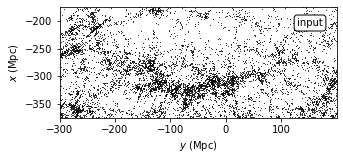

In [6]:
# Fetch the great wall data
X = fetch_great_wall()

adjust_figure(5,2.2)

# First plot: scatter the points
ax1 = plt.subplot(111, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

ax1.set_xlim(ymin, ymax - 0.01)
ax1.set_ylim(xmin, xmax)
    
ax1.set_xlabel('$y$ (Mpc)')
ax1.set_ylabel('$x$ (Mpc)')

plt.show()

## Evaluate KDE with Gaussian Kernel
Use a *Gaussian kernel* to evaluate the kernel density. The function $K(u)$, a smooth function, represents the weight at a given point, which is normalized such that $\int K(u)du = 1$.  
The expression for Gaussian kernel is 

$$K(u) = \frac{1}{ {2\pi}^{\frac{D}{2}} } e^{\frac{-{u}^2}{2}}$$  

where D is the number of dimensions of the parameter space and $u = d(x, x_i) /h$.

Text(0, 0.5, '$x$ (Mpc)')

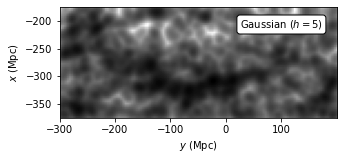

In [7]:
# evaluate Gaussian kernel
def estimate_kde(ker):
    kde = KernelDensity(bandwidth=5, kernel=ker)
    log_dens = kde.fit(X).score_samples(Xgrid)
    dens = X.shape[0] * np.exp(log_dens).reshape((Ny, Nx))
    return dens
   
dens1 = estimate_kde('gaussian')

adjust_figure(5,2.2)
ax = plot_figure(111, dens1.T, "Gaussian $(h=5)$")

ax.set_xlabel('$y$ (Mpc)')
ax.set_ylabel('$x$ (Mpc)')

## Evaluate KDE with Top-hat Kernel
Use a *top-hat (box) kernel* to evaluate the kernel density. The expression for top-hat kernel is 

$$f(z) = \left\{ \begin{array}{rcl}
\frac{1}{V_{D}(1)} & \mbox{if} & |u|\leq1, \\
0 & \mbox{if} & |u|>1.
\end{array}\right.$$  

This kernel gives the most "spread out" estimation for each distribution freature.

Text(0, 0.5, '$x$ (Mpc)')

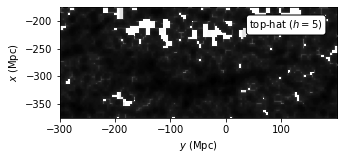

In [8]:
# Third plot: top-hat kernel
dens2 = estimate_kde('tophat')

adjust_figure(5,2.2)
ax = plot_figure(111, dens2.T, "top-hat $(h=5)$")

ax.set_xlabel('$y$ (Mpc)')
ax.set_ylabel('$x$ (Mpc)')

## Evaluate KDE with Exponential Kernel
Use a *exponential kernel* to evaluate the kernel density. The expression for exponential kernel is 

$$K(u) = \frac{1}{D!V_{D}(1)}e^{-|u|}.$$  

where $V_D(r)$ is the volume of a D-dimensional hypersphere of radius r.  
This kernel gives the "sharpest" estimation for each distribution feature.  

Text(0, 0.5, '$x$ (Mpc)')

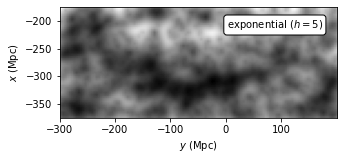

In [9]:
# Fourth plot: exponential kernel
dens3 = estimate_kde('exponential')

adjust_figure(5,2.2)
ax = plot_figure(111, dens3.T, "exponential $(h=5)$")

ax.set_xlabel('$y$ (Mpc)')
ax.set_ylabel('$x$ (Mpc)')

## Evaluate density using K-Nearest-Neighbor Estimation
Another estimator is the K-nearest-neighbor estimator, originally proposed by [Dressler et al. 1980](https://ui.adsabs.harvard.edu/abs/1980ApJ...236..351D/abstract) . In this method, the implied point density at an arbitrary position x is estimated as

$$\hat{f_K}(x) = \frac{K}{V_D(d_K)}$$

where $V_D$ is evaluated volume, and D is the problem dimensionality.  
  
By taking the assumption that the underlying density field is locally constant, we can further simplify this method as

$$\hat{f_K}(x) = \frac{C}{d_K^D}$$

where C is a scaling factor evaluated by requiring that the sum of the product of $\hat{f_K}(x)$ and
pixel volume is equal to the total number of data points.

In this method, we can change parameter k to get different estimation result.
K should be at least 5 because the estimator is biased and has a large variance for smaller K; see [Casertano, S. and Hut, P.](https://ui.adsabs.harvard.edu/abs/1985ApJ...298...80C/abstract)

Text(0, 0.5, '$x$ (Mpc)')

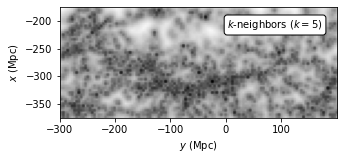

In [10]:
# calculate K Neighbors Density with k = 5
knn5 = KNeighborsDensity('bayesian', 5)
dens_k5 = knn5.fit(X).eval(Xgrid).reshape((Ny, Nx))

# plot K Neighbor with k = 5
adjust_figure(5,2.2)
ax = plot_figure(111, dens_k5.T, "$k$-neighbors $(k=5)$")

ax.set_xlabel('$y$ (Mpc)')
ax.set_ylabel('$x$ (Mpc)')

The fractional accuracy increases with K at the expense of the spatial resolution. Taking k = 40 instead of k = 5, we see different estimation result.

Text(0, 0.5, '$x$ (Mpc)')

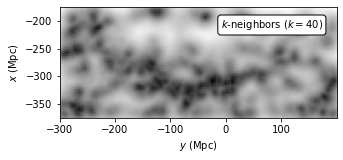

In [11]:
# calculate K Neighbors Density with k = 40
knn40 = KNeighborsDensity('bayesian', 40)
dens_k40 = knn40.fit(X).eval(Xgrid).reshape((Ny, Nx))

# plot K Neighbor with k = 40
adjust_figure(5,2.2)
ax = plot_figure(111, dens_k40.T, "$k$-neighbors $(k=40)$")

ax.set_xlabel('$y$ (Mpc)')
ax.set_ylabel('$x$ (Mpc)')

## Compare Estimated Results

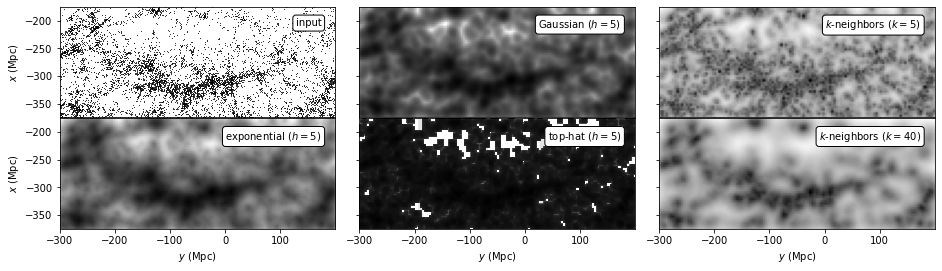

In [14]:
adjust_figure(15,4.4)

# First plot: scatter the points
ax1 = plt.subplot(231, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax1.set_xlim(ymin, ymax - 0.01)
ax1.set_ylim(xmin, xmax)

# Second plot: gaussian kernel
ax2 = plot_figure(232, dens1.T, "Gaussian $(h=5)$")

# Third plot: K nearest neighbor with k=5
ax3 = plot_figure(233, dens_k5.T, "$k$-neighbors $(k=5)$")

# Fourth plot: exponential kernel
ax4 = plot_figure(234, dens3.T, "exponential $(h=5)$")

# Fifth plot: top-hat kernel
ax5 = plot_figure(235, dens2.T, "top-hat $(h=5)$")

# sixth plot: K nearest neighbor with k=40
ax6 = plot_figure(236, dens_k40.T, "$k$-neighbors $(k=40)$")

for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax4, ax5, ax6]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax3, ax5, ax6]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax4]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

## Use Gaussian Mixture Model
GMM calculate the underlying pdf of a point as a sum of multi-dimensional Gaussians using the equation below

$$\rho(x) = Np(x) = N \sum_{j=1}^{M} \alpha_j \mathcal{N}(\mu_j, \Sigma_j)$$

where M is the number of Gaussians, $\mu_j$ is the the location, and $\Sigma_j$ is the covariance of a Gaussian.

converged: True


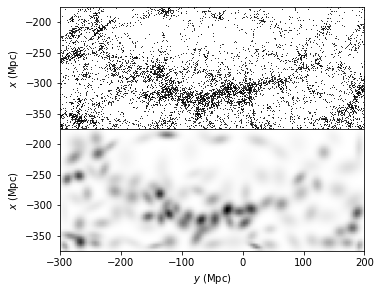

In [13]:
# Calculate GMM
def compute_GMM(n_clusters, max_iter=1000, tol=3, covariance_type='full'):
    clf = GaussianMixture(n_clusters, covariance_type=covariance_type,
                          max_iter=max_iter, tol=tol, random_state=0)
    clf.fit(X)
    print("converged:", clf.converged_)
    return clf

clf = compute_GMM(n_clusters=100)
log_dens = clf.score_samples(Xgrid).reshape(Ny, Nx)

# plot figures
fig = plt.figure(figsize=(5, 4.4))
fig.subplots_adjust(hspace=0, left=0.08, right=0.95, bottom=0.13, top=0.9)

ax = fig.add_subplot(211, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')

ax.set_xlim(ymin, ymax - 0.01)
ax.set_ylim(xmin, xmax)

ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.ylabel(r'$x\ {\rm (Mpc)}$')

ax = fig.add_subplot(212, aspect='equal')
ax.imshow(np.exp(log_dens.T), origin='lower', cmap=plt.cm.binary,
          extent=[ymin, ymax, xmin, xmax])
ax.set_xlabel(r'$y\ {\rm (Mpc)}$')
ax.set_ylabel(r'$x\ {\rm (Mpc)}$')

plt.show()